In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image, ImageDraw
import math
from tqdm import tqdm

In [2]:
device = 'cuda'

img = Image.open('maze_cropped.png')
# img_np = np.array(img)[...,:3] / 255


# obs = torch.tensor(img_np, dtype=torch.float32, device=device).permute(2,0,1)
# obs = obs.unsqueeze(0) # batch

In [3]:
def prepare_input(img, goal_pos, circle_rad: float = 8):
    assert goal_pos.ndim == 2 and goal_pos.shape[-1] == 2, f"{goal_pos.shape}" # (N,2)


    
    W, H = img.width, img.height

    goal_pos_pix = ((1+goal_pos)/2 * torch.tensor([H,W], device=goal_pos.device, dtype=goal_pos.dtype))

    imgs = []
    for center in goal_pos_pix.cpu().numpy():
        img_new = img.copy()

        w,h = center[1], center[0]

        draw = ImageDraw.Draw(img_new)
        draw.ellipse((w-circle_rad, h-circle_rad, w+circle_rad, h+circle_rad), fill = 'blue', outline ='blue')

        img_np = np.array(img_new)[...,:3] / 255
        imgs.append(img_np)

    imgs = np.stack(imgs, axis=0)
    return torch.tensor(imgs, dtype=goal_pos.dtype, device=goal_pos.device).permute(0, 3, 1, 2)

def visualize_obs(obs, idx=0):
    from matplotlib import pyplot as plt
    plt.imshow((obs[idx].cpu().permute(1,2,0).numpy() * 255).astype(int))

def bilinear_interpolate(fmap, pos):
    """
    Returns the bilinear interpolated feature vector at pos.
    
    Parameters:
        fmap (torch.Tensor): The output feature map of a FCN of shape (N, C, H, W)
        pos (torch.Tensor): Tensor of positions of shape (N, 2) where each row is (x, y) ranging from -1 to 1
        
    Returns:
        torch.Tensor: Interpolated feature vectors of shape (N, C)
    """
    
    # Ensure fmap and pos are compatible
    assert fmap.size(0) == pos.size(0), "Batch size of fmap and pos must be the same"

    # Reshape the pos tensor to make it compatible with grid_sample
    grid = pos.unsqueeze(-2).unsqueeze(-2)  # Shape will be (N, 1, 1, 2)

    # Ensure grid and fmap are on the same device
    grid = grid.to(fmap.device)

    # Perform bilinear interpolation
    interpolated_value = F.grid_sample(fmap, grid, mode="bilinear", padding_mode="zeros", align_corners=True)

    # Remove the spatial dimensions and return the interpolated feature vector
    return interpolated_value.squeeze(-1).squeeze(-1)


In [4]:
class ScoreModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcn = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True).backbone

        self.score_head = torch.nn.Sequential(
            torch.nn.Linear(2048,128),
            torch.nn.SiLU(inplace=True),
            torch.nn.Linear(128,2)
        )

    def forward(self, pos: torch.Tensor, obs: torch.Tensor):
        assert pos.ndim == 2 and pos.shape[-1] == 2, f"{pos.shape}"
        assert obs.ndim == 4 and obs.shape[-3] == 3, f"{obs.shape}"
        assert pos.shape[0] == obs.shape[0], f"{pos.shape, obs.shape}"

        score_map = self.score_head(self.fcn(obs)['out'].permute(0,2,3,1)).permute(0,3,1,2)
        score = bilinear_interpolate(fmap=score_map, pos=pos)

        return score

In [5]:
model = ScoreModel().to(device)

Using cache found in /home/junwoo/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [6]:
diffuse_t = 0.05
N_batch = 1
x0 = (torch.rand(N_batch,2, device=device, dtype=torch.float32)*2 - 1.) * 0.1
obs = prepare_input(img, goal_pos=x0)

x = torch.randn(N_batch, 2, device=device, dtype=torch.float32) * math.sqrt(diffuse_t) + x0

score = model(x, obs)

torch.Size([1, 2, 28, 28])


In [ ]:
diffuse_t = 0.05
N_batch = 10


for iters in range(1000):
    optim.zero_grad()
    # x0 = torch.tensor([[-1,-1], [0., 0.]], device=device, dtype=torch.float32)
    x0 = (torch.rand(N_batch,2, device=device, dtype=torch.float32)*2 - 1.) * 0.1
    obs = prepare_input(img, goal_pos=x0)

    
    x = torch.randn(N_batch, 2, device=device, dtype=torch.float32) * math.sqrt(diffuse_t) + x0

    target_score = x0-x
    target_score_normalized = target_score # * math.sqrt(diffuse_t)

    # obs_diffused = prepare_input(img, goal_pos=x)
    # visualize_obs(obs_diffused, 0)

    score = model(pos=x, obs=obs)

    loss = F.mse_loss(score, target_score)

    loss.backward()
    optim.step()

    if iters % 10 == 0:
        print(f"iter {iters}: {loss.item()}")

In [11]:
# torch.save(model.state_dict(), "checkpoint.pt")

In [13]:
model = model.eval()

In [84]:
x0 = torch.tensor([[-0.5,0.5]]*20, device=device, dtype=torch.float32)
obs = prepare_input(img, goal_pos=x0)

with torch.no_grad():
    score = model(pos=x0, obs=obs)

In [85]:
dt = 0.01

x_trace = []
x = x0
for _ in tqdm(range(400)):
    with torch.no_grad():
        score = model(pos=x, obs=obs)

    x = x + (score * dt / 2) + (torch.randn_like(x) * math.sqrt(dt) * 0.1)
    # x_trace.append(x)

100%|██████████| 400/400 [00:17<00:00, 22.71it/s]


In [86]:
def draw_samples(img, goal_pos, circle_rad: float = 1.0):
    assert goal_pos.ndim == 2 and goal_pos.shape[-1] == 2, f"{goal_pos.shape}" # (N,2)


    
    W, H = img.width, img.height

    goal_pos_pix = ((1+goal_pos)/2 * torch.tensor([H,W], device=goal_pos.device, dtype=goal_pos.dtype))

    img_new = img.copy()
    draw = ImageDraw.Draw(img_new)

    for center in goal_pos_pix.cpu().numpy():
        w,h = center[1], center[0]
        draw.ellipse((w-circle_rad, h-circle_rad, w+circle_rad, h+circle_rad), fill = 'blue', outline ='blue')

    return img_new

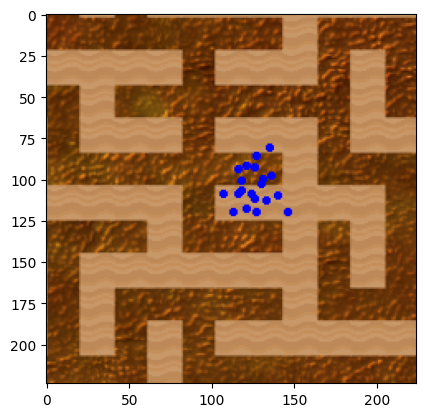

In [87]:
img_sample = draw_samples(img, x.cpu(), circle_rad=2.0)
from matplotlib import pyplot as plt
plt.imshow(np.array(img_sample))

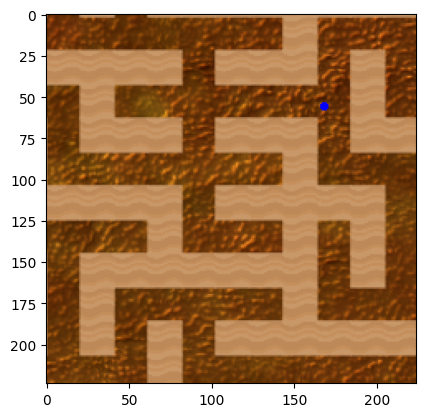

In [88]:
img_sample = draw_samples(img, x0.cpu(), circle_rad=2.0)
from matplotlib import pyplot as plt
plt.imshow(np.array(img_sample))

In [ ]:
afds

In [ ]:
score.shape

In [ ]:
target_score.shape

In [ ]:
F.mse_loss(score, target_score)

In [ ]:
score

In [ ]:
x = torch.tensor([[-1., -1.]], device=device)
score = model(pos=x, obs=obs)

In [ ]:
x0 = torch.tensor([[0., 0.]], device=device)

In [ ]:
img

In [ ]:
pos = torch.tensor([[-1., -1.]], device=device)

In [ ]:
score

In [ ]:
score_map[:,:,0,0]

In [ ]:


# Example usage
fmap = torch.randn(4, 512, 13, 13)  # Sample feature map with batch size 4
pos = torch.tensor([[0.5, -0.5], [-0.8, 0.4], [0.2, 0.3], [-0.1, -0.6]])  # Sample positions
interpolated_vectors = bilinear_interpolate(fmap, pos)
print(interpolated_vectors.shape)  # Expected: torch.Size([4, 512])

In [ ]:
interpolated_vector.shape

In [ ]:
score.shape